<ipython-input-4-d7eb46af4dc6>:37: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),


Found 2052 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.
Epoch 1/45


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 191ms/step - accuracy: 0.2083 - loss: 2.6345 - val_accuracy: 0.2719 - val_loss: 2.3710
Epoch 2/45
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.3076 - loss: 2.0627 - val_accuracy: 0.2719 - val_loss: 3.3398
Epoch 3/45
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.3563 - loss: 1.8783 - val_accuracy: 0.3801 - val_loss: 1.8288
Epoch 4/45
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.4090 - loss: 1.6623 - val_accuracy: 0.4532 - val_loss: 1.9896
Epoch 5/45
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.3874 - loss: 1.6501 - val_accuracy: 0.4810 - val_loss: 1.4189
Epoch 6/45
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.4142 - loss: 1.5270 - val_accuracy: 0.4810 - val_loss: 1.3454
Epoch 7/45
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.4428 - loss: 1.3951 - val_accuracy: 0.5058 - val_loss: 1.2281
Epoch 8/45
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.4449 - loss: 1.3922 - val_accuracy: 0.4927 - val_loss: 

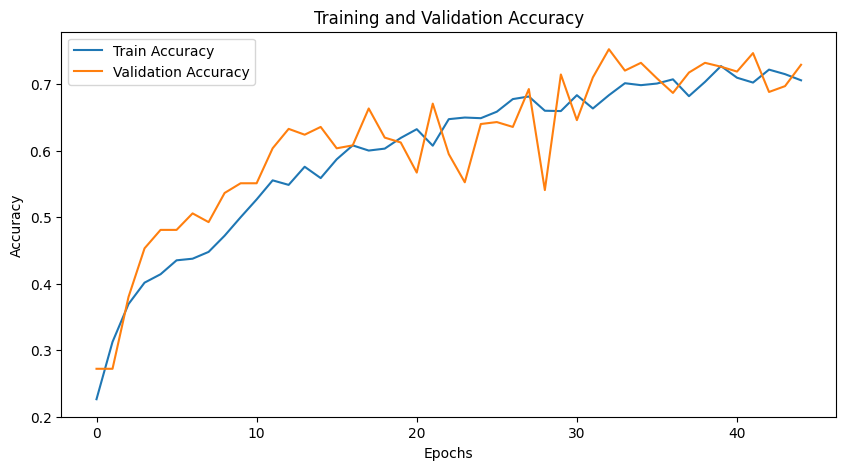

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


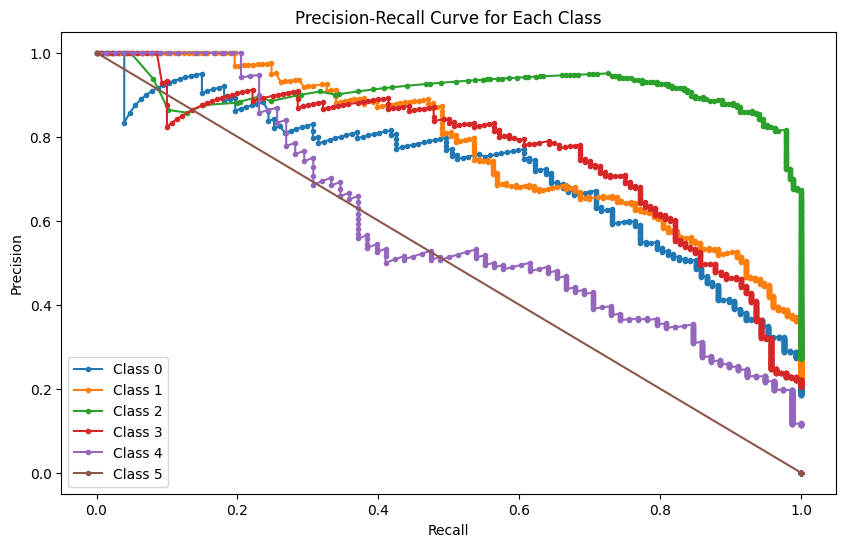

In [4]:
import os
import cv2
import numpy as np
import random
import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, Input, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve

# Set dataset paths
dataset_path = "/kaggle/input/thermal-images-diseased-healthy-leaves-paddy/thermal images UL"
output_path = "/kaggle/working/expanded_dataset"
final_dataset_path = "/kaggle/working/final_processed_dataset"

# Ensure only valid labels are considered
valid_labels = {"BLB", "Blast", "healthy", "hispa", "leaf folder", "leaf spot"}

# Create necessary directories
os.makedirs(output_path, exist_ok=True)
os.makedirs(final_dataset_path, exist_ok=True)

# Define augmentations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    A.RandomResizedCrop(height=64, width=64, scale=(0.7, 1.0), p=0.5),
    A.GridDistortion(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5)
])

# Define image processing functions
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)

def apply_filtering(img):
    return cv2.medianBlur(cv2.GaussianBlur(img, (5, 5), 0), 5)

def apply_thresholding(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

def apply_morphology(img):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

# Expand dataset to 220 images per label
for label in os.listdir(dataset_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(dataset_path, label)
    save_path = os.path.join(output_path, label)
    os.makedirs(save_path, exist_ok=True)
    images = [os.path.join(label_path, img) for img in os.listdir(label_path)]
    
    while len(images) < 220:
        img_path = random.choice(images)
        img = cv2.imread(img_path)
        augmented = augmentations(image=img)["image"]
        cv2.imwrite(os.path.join(save_path, f"aug_{len(images)}.jpg"), augmented)
        images.append(img_path)

# Apply Processing Techniques
for label in os.listdir(output_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(output_path, label)
    save_label_path = os.path.join(final_dataset_path, label)
    os.makedirs(save_label_path, exist_ok=True)
    
    for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        img = cv2.imread(img_path)
        
        cv2.imwrite(os.path.join(save_label_path, f"orig_{img_file}"), img)
        cv2.imwrite(os.path.join(save_label_path, f"clahe_{img_file}"), apply_clahe(img))
        cv2.imwrite(os.path.join(save_label_path, f"filtered_{img_file}"), apply_filtering(img))
        cv2.imwrite(os.path.join(save_label_path, f"thresh_{img_file}"), apply_thresholding(img))
        cv2.imwrite(os.path.join(save_label_path, f"morph_{img_file}"), apply_morphology(img))

# Load dataset and split into Train/Validation/Test
all_images, all_labels = [], []
label_map = {label: idx for idx, label in enumerate(valid_labels)}

for label in valid_labels:
    label_path = os.path.join(final_dataset_path, label)
    for img_file in os.listdir(label_path):
        all_images.append(os.path.join(label_path, img_file))
        all_labels.append(label_map[label])

train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(all_images, all_labels, test_size=0.4, stratify=all_labels, random_state=42)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
# Convert labels to strings
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))

# Create data generators with augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=45,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_imgs, "class": train_labels}),
    x_col="filename",
    y_col="class",
    target_size=(64, 64),
    batch_size=32,
    class_mode="sparse"
)

val_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": val_imgs, "class": val_labels}),
    x_col="filename",
    y_col="class",
    target_size=(64, 64),
    batch_size=32,
    class_mode="sparse"
)

test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": test_imgs, "class": test_labels}),
    x_col="filename",
    y_col="class",
    target_size=(64, 64),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)

def create_segnet_model(input_shape, num_classes):
    # Input
    inputs = Input(shape=input_shape)
    
    # Encoder
    # Block 1
    x = Conv2D(8, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Block 2
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Block 3
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Decoder (Modified for classification instead of segmentation)
    # Block 4
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Block 5
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Classification head
    x = Conv2D(8, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Create and compile the SegNet model
model = create_segnet_model((64, 64, 3), len(valid_labels))
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model with 45 epochs
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=45,
    class_weight=class_weight_dict
)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_gen)
print("Final Test Accuracy:", test_accuracy)

# Plot training/validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Compute and plot PR curve
num_classes = len(valid_labels)
y_true = tf.keras.utils.to_categorical(test_gen.classes, num_classes)
y_probs = model.predict(test_gen)
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    plt.plot(recall, precision, marker='.', label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()